In [299]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob
import datetime

from RNN import RNN
from CNN import CNN
from Transformer import Transformer

from utils import series_to_supervised



dataset = pd.read_csv('c://aadm/584all.csv', header=0, infer_datetime_format=True, parse_dates=['ts'], index_col=['ts'])


In [300]:
def impute_mean(df, column, by='hour'):
  # impute with mean by hours
  # in the future by could be another mean grouping criterion
  df[by] = df.index.hour
  df[column] = df.groupby(by)[column].apply(lambda x: x.fillna(x.mean()))
  df.drop(by, axis=1, inplace=True)

In [301]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16243 entries, 2025-05-14 00:00:00 to 2025-07-09 09:30:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   glucose    14815 non-null  float64
 1   eff_carbs  16243 non-null  float64
 2   eff_ins    16243 non-null  float64
dtypes: float64(3)
memory usage: 507.6 KB


In [302]:
# We choose to keep only Global_active_power
to_drop = ['eff_ins']
dataset.drop(columns=to_drop, inplace=True)

In [303]:
dataset.head()

,glucose,eff_carbs
ts,,
2025-05-14 00:00:00,48.0,0.0
2025-05-14 00:05:00,48.0,0.0
2025-05-14 00:10:00,53.0,0.0
2025-05-14 00:15:00,63.0,0.0
2025-05-14 00:20:00,69.0,0.0


In [304]:
# #mean imputation
impute_mean(dataset, 'glucose')
#dataset.describe()

In [305]:
#dataset['glucose']= dataset.glucose.interpolate(method="spline",order=3)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16243 entries, 2025-05-14 00:00:00 to 2025-07-09 09:30:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   glucose    16243 non-null  float64
 1   eff_carbs  16243 non-null  float64
dtypes: float64(2)
memory usage: 380.7 KB


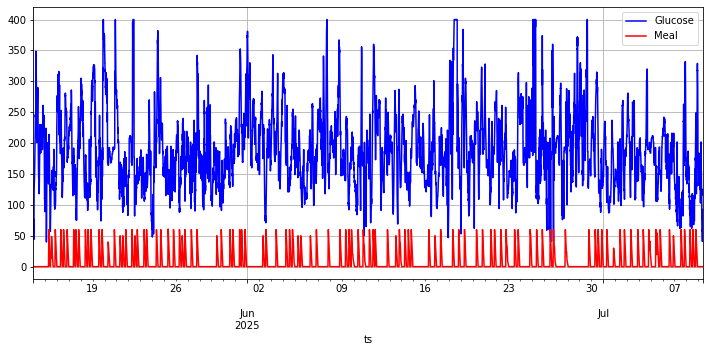

In [306]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.xlabel('cgm and meal')

dataset.glucose.plot(color='blue', grid=True, label='Glucose')
dataset.eff_carbs.plot(color='red', grid= True, label='Meal')
plt.legend()
plt.show()

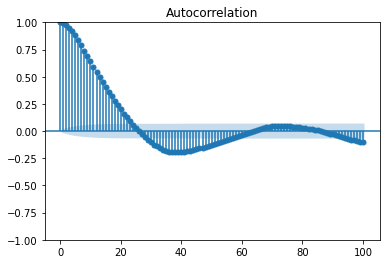

In [307]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dataset['eff_carbs'],lags=100);
#plot_acf(dataset['glucose'])

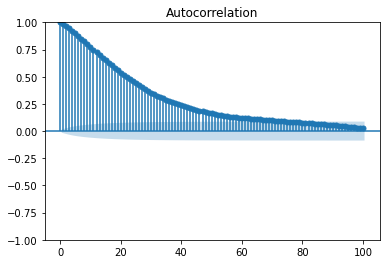

In [308]:
plot_acf(dataset['glucose'],lags=100);

In [309]:
#Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
X = dataset.glucose.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.574078
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [310]:
X1= dataset.eff_carbs.values
result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.806504
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [251]:
# Function to print out results in customised manner
from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(X)
kpss_test(X1)

Results of KPSS Test:
Test Statistic            1.247213
p-value                   0.010000
#Lags Used               73.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test:
Test Statistic            1.176027
p-value                   0.010000
#Lags Used               73.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\eacun\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\eacun\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [62]:
#differentiating eight times the time series to obtain stationarity
dataset['eff_carbs'] = dataset['eff_carbs'].diff().diff()
#dataset['glucose'] = dataset['glucose'].diff()

In [63]:
# # spline smoothing
# import rpy2
# import rpy2.rinterface
# %load_ext rpy2.ipython
# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr
# splines = importr('splines') 
# x_train=np.arange(len(dataset))
# y_train=dataset['glucose']
# r_y = robjects.FloatVector(y_train)
# r_x = robjects.FloatVector(x_train)
# r_smooth_spline = robjects.r['smooth.spline'] #extract R function# run smoothing function
# spline1 = r_smooth_spline(x=r_x,y=r_y, spar=.01)
# ySpline=np.array(robjects.r['predict'](spline1,robjects.FloatVector(x_train)).rx2('y'))
# # print(ySpline)
# # plt.figure(figsize=(12,6))
# # plt.scatter(x_train,y_train,c="blue")
# # plt.plot(x_train,ySpline,c='red')

In [64]:
# # #Imputation using Kalman smoothing and spline smoothing
# from tsmoothie.smoother import *
# from tsmoothie.utils_func import create_windows
# #smoother1 = SplineSmoother(n_knots=100, spline_type='cubic_spline')
# #smoother1.smooth(cgmtrainclean[['glucose']].T)
# smoother = KalmanSmoother(component='level_season', 
#                            component_noise={'level':0.1, 'season':0.1},n_seasons=7)
# smoother.smooth(dataset[['glucose']].T)
# glucosekf=smoother.smooth_data[0]
# dataset['glucose']=glucosekf
#dataset['glucose']=ySpline
# # #smoother1.smooth_data[0].mean()

In [65]:
import time
start_time = time.time()
look_back = 12
n_features = dataset.shape[1]
print("features:",n_features)
# Walk-forward data split to avoid data leakage
X_train, y_train, X_test, y_test, scale_X = series_to_supervised(dataset, train_size=0.8, n_in=look_back, n_out=6, target_column='glucose', dropnan=True, scale_X=False)
print(X_train.shape,X_test.shape)
print(X_train)
print(y_train)
# reshape input to be 3D [samples, timesteps, features]
X_train_reshaped = X_train.values.reshape((-1,look_back,n_features))
X_test_reshaped = X_test.values.reshape((-1,look_back,n_features))
y_train_reshaped = y_train.values
y_test_reshaped = y_test.values
print(X_train_reshaped.shape,X_test_reshaped.shape)


features: 2
(12979, 24) (3245, 24)
                     eff_carbs(t-12)  target(t-12)  eff_carbs(t-11)  \
ts                                                                    
2025-05-14 01:10:00              0.0          53.0              0.0   
2025-05-14 01:15:00              0.0          63.0              0.0   
2025-05-14 01:20:00              0.0          69.0              0.0   
2025-05-14 01:25:00              0.0          74.0              0.0   
2025-05-14 01:30:00              0.0          77.0              0.0   
...                              ...           ...              ...   
2025-06-28 02:20:00              0.0         247.0              0.0   
2025-06-28 02:25:00              0.0         250.0              0.0   
2025-06-28 02:30:00              0.0         253.0              0.0   
2025-06-28 02:35:00              0.0         255.0              0.0   
2025-06-28 02:40:00              0.0         254.0              0.0   

                     target(t-11)  eff_ca

In [66]:
## Testing the Transformer
tr = Transformer()
tr.train(X_train_reshaped,y_train_reshaped)
a=tr.evaluate(X_test_reshaped,y_test_reshaped)
print(a)
#_, rmse_result, mae_result, smape_result, r2_result = tr.evaluate(X_test_reshaped,y_test_reshaped)
#print('Result \n RMSE = %.2f [kWh] \n MAE = %.2f [kWh]\n R2 = %.1f [%%]' % (rmse_result,
#                                                                            mae_result,
#        

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12, 2)]      0           []                               
                                                                                                  
 layer_normalization_16 (LayerN  (None, 12, 2)       4           ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 12, 2)       11266       ['layer_normalization_16[0][0]', 
 eadAttention)                                                    'layer_normalization_16[0][0]'] 
                                                                                            

 ambda)                                                           'tf.__operators__.add_21[0][0]']
                                                                                                  
 layer_normalization_23 (LayerN  (None, 12, 2)       4           ['tf.__operators__.add_22[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv1d_22 (Conv1D)             (None, 12, 4)        12          ['layer_normalization_23[0][0]'] 
                                                                                                  
 dropout_25 (Dropout)           (None, 12, 4)        0           ['conv1d_22[0][0]']              
                                                                                                  
 conv1d_23 (Conv1D)             (None, 12, 2)        10          ['dropout_25[0][0]']             
          


Epoch 10: loss improved from 2201.65063 to 2113.72510, saving model to checkpoint\Transformer.test Mon Dec 19 20 50 35 2022.hdf5
203/203 [==============================] - 27s 131ms/step - loss: 2113.7251 - rmse: 45.7939 - mae: 35.1405 - smape: 9.6496 - coeff_determination: 0.4776
Epoch 11/50
203/203 [==============================] - ETA: 0s - loss: 1980.2809 - rmse: 44.3486 - mae: 33.9551 - smape: 9.2997 - coeff_determination: 0.5130WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination

Epoch 11: loss improved from 2113.72510 to 1980.28088, saving model to checkpoint\Transformer.test Mon Dec 19 20 50 35 2022.hdf5
203/203 [==============================] - 31s 150ms/step - loss: 1980.2809 - rmse: 44.3486 - mae: 33.9551 - smape: 9.2997 - coeff_determination: 0.5130
Epoch 12/50
203/203 [==============================] - ETA: 0s - loss: 1875.0004 - rmse: 43.1345 - mae: 33.0348 - smape: 9.


Epoch 24: loss improved from 1343.01379 to 1310.48523, saving model to checkpoint\Transformer.test Mon Dec 19 20 50 35 2022.hdf5
203/203 [==============================] - 29s 143ms/step - loss: 1310.4852 - rmse: 35.9779 - mae: 27.2187 - smape: 7.4371 - coeff_determination: 0.6779
Epoch 25/50
203/203 [==============================] - ETA: 0s - loss: 1291.9220 - rmse: 35.7281 - mae: 27.0194 - smape: 7.3649 - coeff_determination: 0.6801WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination

Epoch 25: loss improved from 1310.48523 to 1291.92200, saving model to checkpoint\Transformer.test Mon Dec 19 20 50 35 2022.hdf5
203/203 [==============================] - 37s 181ms/step - loss: 1291.9220 - rmse: 35.7281 - mae: 27.0194 - smape: 7.3649 - coeff_determination: 0.6801
Epoch 26/50
203/203 [==============================] - ETA: 0s - loss: 1250.9000 - rmse: 35.1814 - mae: 26.5553 - smape: 7.


Epoch 38: loss improved from 1071.89148 to 1048.52258, saving model to checkpoint\Transformer.test Mon Dec 19 20 50 35 2022.hdf5
203/203 [==============================] - 29s 144ms/step - loss: 1048.5226 - rmse: 32.1616 - mae: 24.2244 - smape: 6.6042 - coeff_determination: 0.7411
Epoch 39/50
203/203 [==============================] - ETA: 0s - loss: 1033.8433 - rmse: 31.9747 - mae: 24.1340 - smape: 6.5911 - coeff_determination: 0.7456WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,rmse,mae,smape,coeff_determination

Epoch 39: loss improved from 1048.52258 to 1033.84326, saving model to checkpoint\Transformer.test Mon Dec 19 20 50 35 2022.hdf5
203/203 [==============================] - 27s 131ms/step - loss: 1033.8433 - rmse: 31.9747 - mae: 24.1340 - smape: 6.5911 - coeff_determination: 0.7456
Epoch 40/50
203/203 [==============================] - ETA: 0s - loss: 1048.1494 - rmse: 32.1333 - mae: 24.0503 - smape: 6.

In [67]:
print(a.shape)

(3245, 6)


In [68]:
print(type(a))

<class 'numpy.ndarray'>


In [69]:
actual=y_test.to_numpy()

In [70]:
#print(actual)
diff=actual-a

In [71]:
print("RMSE:",np.sqrt(np.mean((diff)**2,axis=0)).mean())

RMSE: 17.109426023498298


In [72]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 1498.1145505905151 seconds ---
